<h1>Dados Covid-19 - Pré-processamento</h1>

Dados obtidos do site <a href="https://brasil.io">Brasil.io</a>. O qual disponibiliza não apenas os dados como também documentação, diversas visualizações dos dados, uma API de acesso além do código fonte de tudo.

URL direta dos dados: <a href="https://brasil.io/dataset/covid19/files/">https://brasil.io/dataset/covid19/files/</a>.

Data de download: 02/03/2021 

<h2>Dados Agregados</h2>
Os dados diários variam em excesso. Deve-se levar em conta erros que podem ocorrer, como por exemplo, aos finais de semana as notificações podem ser deficitárias, também podem ocorrer atrasos de notificações.

Agregar os dados por semana pode ajudar a minimizar problemas como grandes picos de mortes e número de mortes negativas, suavizando grandes variações.

<h2>Número de Mortes por Semana</h2>

Carga da biblioteca gráfica:

In [1]:
library("ggplot2")

Carga dos dados.

In [2]:
dados <- read.csv("../input/covid19/caso.csv", header = TRUE, stringsAsFactors = FALSE)

Vamos manter apenas os dados necessários:

In [3]:
dados <- dados[dados$state == "RJ" & dados$place_type == "city", ]
dados <- dados[ , - c(2, 4, 9)] # state, place_type, estimated_population_2019
dados <- dados[dados$city != "Importados/Indefinidos", ]

<h3>Número de mortes por dia</h3>
Vamos criar um novo atributo com o número de mortes por dia:

In [4]:
dados$deaths_day <- 0

municipios <- sort(unique(dados$city))

for (municipio in municipios) {
  indices <- sort(dados[dados$city == municipio, "order_for_place"])
  acumulado <- 0
  for (indice in indices) {
    mortes_no_dia <- dados[dados$city == municipio & dados$order_for_place == indice, "deaths"] - acumulado
    dados[dados$city == municipio & dados$order_for_place == indice, "deaths_day"] <- mortes_no_dia
    acumulado <- dados[dados$city == municipio & dados$order_for_place == indice, "deaths"]
  }
}

Como ficaram os dados?

In [5]:
max(dados$deaths_day)

min(dados$deaths_day)

[1] 307

[1] -111

<h3>Média de mortes por semana</h3>
Que tal a média de mortes por semana? Vamos fazer:

Primeiro todos tem de ter o mesmo numero de datas

In [6]:
# seleciona apenas colunas de interesse
temp <- dados[ , c("date", "city", "deaths_day")]

# todas as datas que existem no conjunto de dados
datas <- sort(unique(temp$date))

linha <- nrow(temp)
for (municipio in municipios) {
  for (data in datas) {
    if (nrow(temp[temp$city == municipio & temp$date == data,]) == 0) {
      linha <- linha + 1
      temp[(linha), "date"] <- data
      temp[(linha), "city"] <- municipio
      temp[(linha), "deaths_day"] <- 0 
    }
  }
}

Funcionou? Todos tem o mesmo número de datas?

In [7]:
nrow(temp) / length(datas) == length(municipios)

[1] TRUE

Calcular o número de mortes semanal por municipio:

In [8]:
temp$week <- 0

datas <- sort(unique(temp$date))

# Para cada data o numero de sua semana
for (municipio in municipios) {
  i <- 0
  for (data in datas) {
    temp[temp$city == municipio & temp$date == data, "week"] <- as.integer(i / 7) + 1
    i <- i + 1
  }
}

# Semanas, cidades e média de mortes de cada semana:
semanal <- data.frame(week = 0, city = "", mean_deaths_week = 0, stringsAsFactors = FALSE)

semanas <- sort(unique(temp$week))

i <- 1
for (municipio in municipios) {
  for (semana in semanas) {
    total <- sum(temp[temp$city == municipio & temp$week == semana, "deaths_day"])
    linhas <- nrow(temp[temp$city == municipio & temp$week == semana, ])
    semanal[i, "week"] <- semana
    semanal[i, "city"] <- municipio
    semanal[i, "mean_deaths_week"] <- total / linhas
    i<- i + 1
  }
}

Deu certo? Vejamos:

In [9]:
any(semanal$mean_deaths_week < 0)

[1] TRUE

Pouco provável que seja negativa a média de mortes em uma semana...

In [10]:
semanal[semanal$mean_deaths_week < 0, ]

,week,city,mean_deaths_week
,<dbl>,<chr>,<dbl>
200,44,Areal,-0.1428571
226,18,Armação dos Búzios,-0.1428571
526,6,Bom Jesus do Itabapoana,-0.1428571
637,13,Cachoeiras de Macacu,-0.1428571
1368,16,Guapimirim,-0.1428571
1663,51,Itaocara,-0.1428571
2073,45,Mangaratiba,-0.1428571
3293,17,Rio Bonito,-0.1428571
3305,29,Rio Bonito,-0.1428571


Poucas ocorrências... Em cidades pequenas, pode acontecer...
Vamos pegar dois exemplos:

In [11]:
temp[temp$city == "Areal" & temp$week == 44,]
temp[temp$city == "São Gonçalo" & temp$week == 26,]

,date,city,deaths_day,week
,<chr>,<chr>,<dbl>,<dbl>
799826,2021-01-18,Areal,0,44
799827,2021-01-17,Areal,0,44
799828,2021-01-16,Areal,0,44
799829,2021-01-13,Areal,-1,44
799830,2021-01-12,Areal,0,44
799831,2021-01-11,Areal,0,44
799832,2021-01-10,Areal,0,44


,date,city,deaths_day,week
,<chr>,<chr>,<dbl>,<dbl>
825061,2020-09-12,São Gonçalo,-1,26
825062,2020-09-11,São Gonçalo,-2,26
825063,2020-09-10,São Gonçalo,0,26
825064,2020-09-09,São Gonçalo,1,26
825065,2020-09-08,São Gonçalo,0,26
825066,2020-09-07,São Gonçalo,0,26
825067,2020-09-06,São Gonçalo,0,26


É... aconteceu...
Sem problemas!

Vejamos o gráfico...

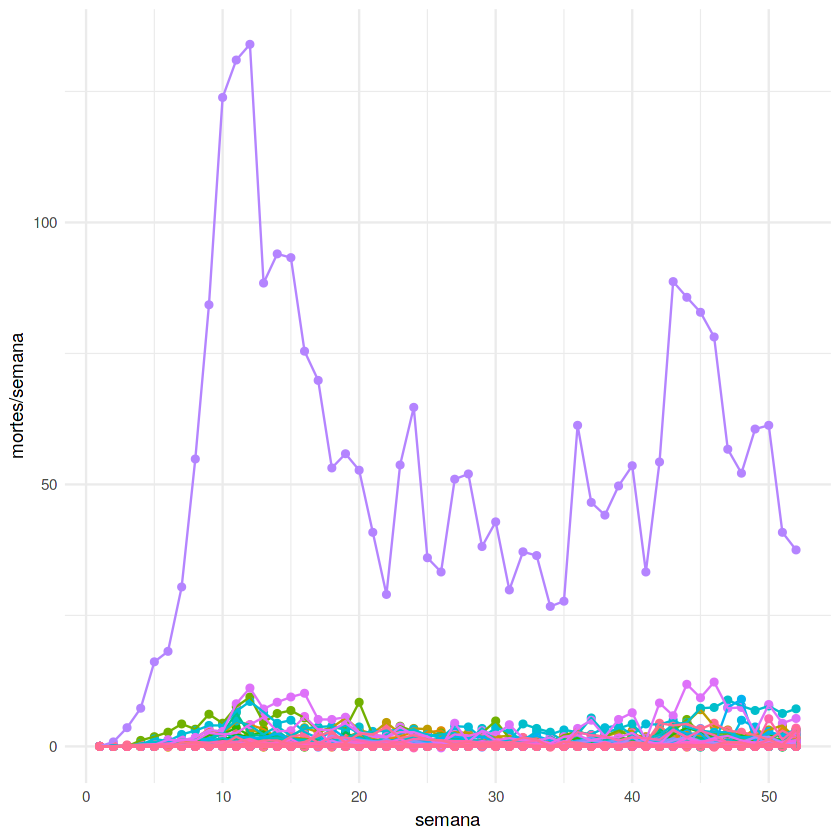

In [12]:
ggplot(semanal, aes(x=week, y=mean_deaths_week, group=city)) +
  geom_point(aes(color=city), show.legend = FALSE) +
  geom_line(aes(color=city), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana") +
  theme_minimal()

<h4>Média de mortes por semana por 100k habitantes</h4>

In [13]:
semanal$mean_deaths_week_100k_inhabitants <- 0

municipios <- sort(unique(dados$city))
for (municipio in municipios) {
  populacao <- unique(dados[dados$city == municipio, "estimated_population"])
  semanal[semanal$city == municipio, "mean_deaths_week_100k_inhabitants"] <- 100000 * semanal[semanal$city == municipio, "mean_deaths_week"] / populacao
}

O gráfico:

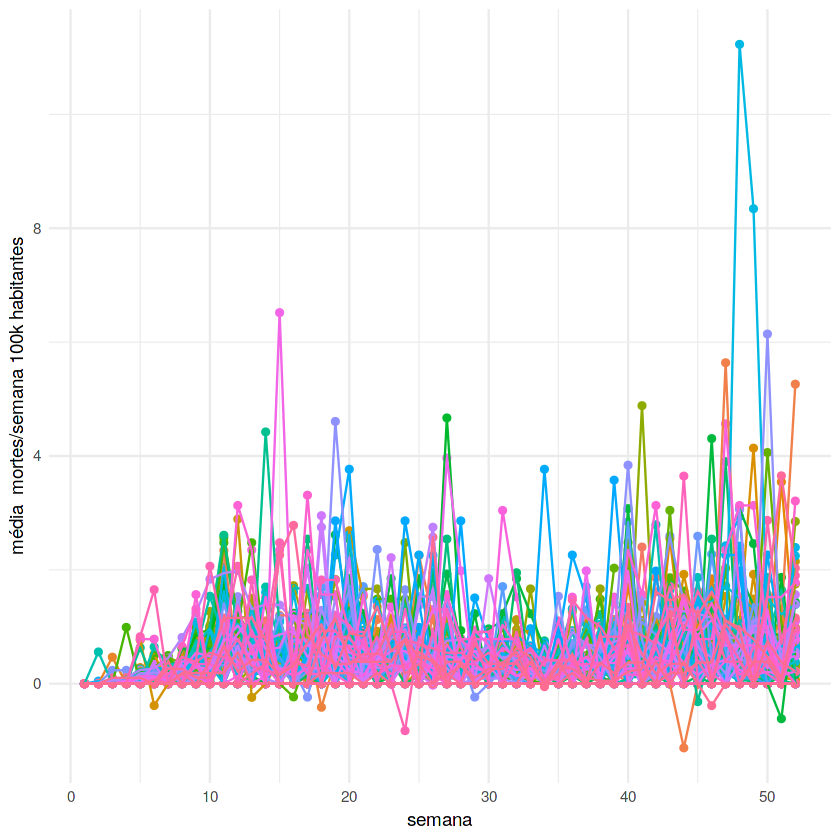

In [14]:
ggplot(semanal, aes(x=week, y=mean_deaths_week_100k_inhabitants, group=city)) +
  geom_point(aes(color=city), show.legend = FALSE) +
  geom_line(aes(color=city), show.legend = FALSE) +
  labs(x = "semana", y = "média  mortes/semana 100k habitantes") +
  theme_minimal()

<h4>Padronização por z-score para a média de mortes por semana por 100k habitantes</h4>

In [15]:
semanal$mean_deaths_week_100k_zscore <- 0

municipios <- sort(unique(dados$city))
for (municipio in municipios) {
  media <- mean(semanal[semanal$city == municipio, "mean_deaths_week_100k_inhabitants"], na.rm = TRUE)
  desvio_padrao <- sd(semanal[semanal$city == municipio, "mean_deaths_week_100k_inhabitants"], na.rm = TRUE)
  semanal[semanal$city == municipio, "mean_deaths_week_100k_zscore"] <- ((semanal[semanal$city == municipio, "mean_deaths_week_100k_inhabitants"] - media) / desvio_padrao)
}

O gráfico:

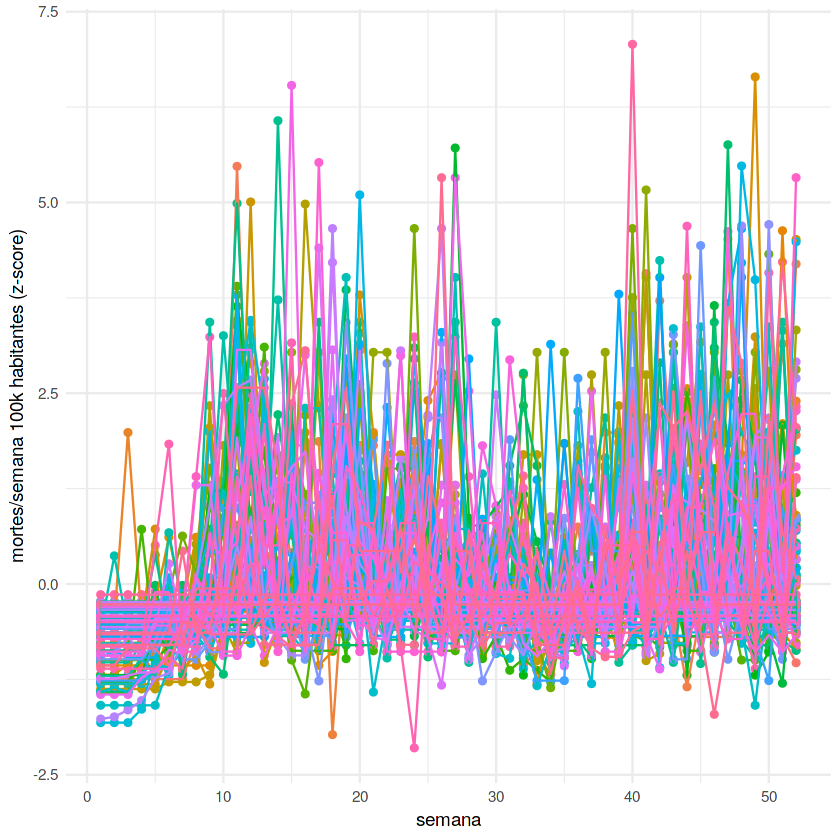

In [16]:
ggplot(semanal, aes(x=week, y=mean_deaths_week_100k_zscore, group=city)) +
  geom_point(aes(color=city), show.legend = FALSE) +
  geom_line(aes(color=city), show.legend = FALSE) +
  labs(x = "semana", y = "mortes/semana 100k habitantes (z-score)") +
  theme_minimal()

<h4>Tendência semanal:</h4>
Vamos verificar, a cada semana, a tendência de alta (aumento >= 15%), estabilidade (variações de até 15% positiva ou negativa), ou queda (queda >= 15%).
Começando pelo cálculo da mudança percentual.

In [17]:
semanal$percentage_change <- 0

municipios <- sort(unique(semanal$city))
semanas <- sort(unique(semanal$week))

for (municipio in municipios) {
  ultimas_semanas <- c(0, 0)
  
  i <- 1 # indice de elementos do municipio
  for (semana in semanas) {
    semana_atual <- semanal[semanal$city == municipio & semanal$week == semana, "mean_deaths_week"]
    ultimas_semanas[i %% 2 + 1] <- semana_atual
    
    mudanca_percentual <- 0
    if (semana_atual != 0) {
      if (i > 2) {
        mudanca_percentual <- semana_atual / ultimas_semanas[(i + 1) %% 2 + 1] - 1
      } else {
        mudanca_percentual <- semana_atual / ultimas_semanas[2] - 1
      }
      
      if (is.infinite(mudanca_percentual)) {  # divisao por zero (Inf)?
        mudanca_percentual <- 1
        if (semana_atual < 0) {
          mudanca_percentual <- -1
        }
      }
    }
    semanal[semanal$city == municipio & semanal$week == semana, "percentage_change"] <- mudanca_percentual
    
    i <- i + 1
  }
}

<h4>Tendência da média (2 semanas)</h4>

In [18]:
tendencia <- function(x) {
  if (x > 0.15) {
    return(1)
  }
  if (x < -0.15) {
    return(-1)
  }
  return(0)
}

semanal$trend <- unlist(lapply(semanal$percentage_change,  FUN = tendencia))

O gráfico:

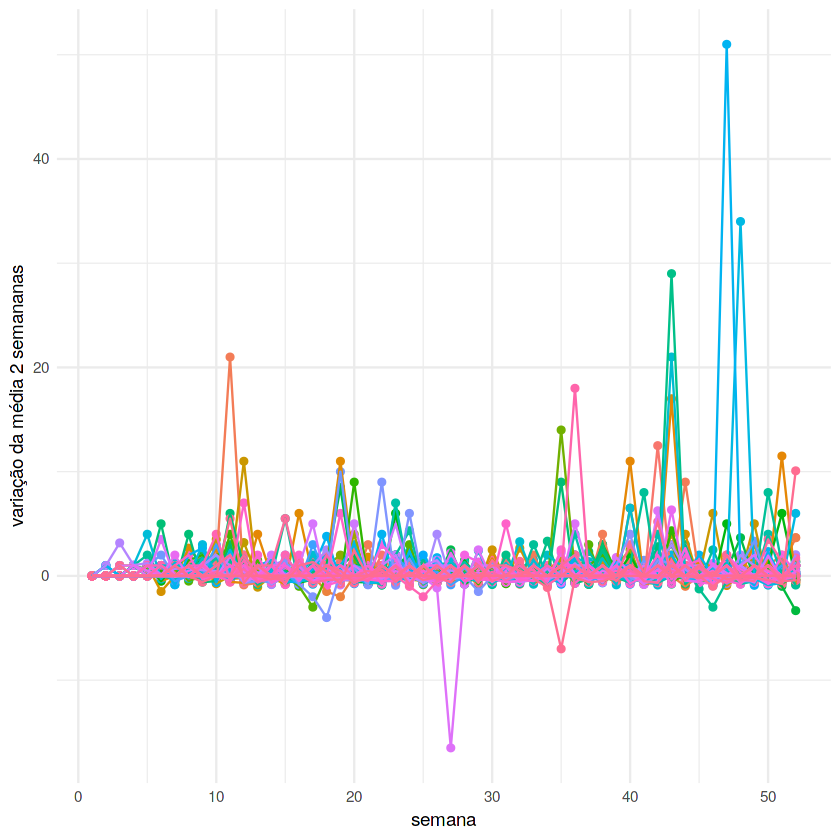

In [19]:
ggplot(semanal, aes(x=week, y=percentage_change, group=city)) +
  geom_point(aes(color=city), show.legend = FALSE) +
  geom_line(aes(color=city), show.legend = FALSE) +
  labs(x = "semana", y = "variação da média 2 semananas") +
  theme_minimal()